# Compare song->neural->mtn predictions on WTG data

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import sys

from aux import load_npy
from disp import set_plot
from my_torch import skl_fit_ridge

cc = np.concatenate

NSPLIT = 30
STRAIN_FILE = 'data/simple/strains.csv'

FIT_KWARGS = {'alpha': 100000}

TWDWS = [.03, 1, 60]
NSPLIT_SAVE_Y_HAT = 3

In [2]:
NRL_MDL = 'ma'  # mult-adapt neural model
STRAIN = 'WTG'

DF_STRAIN = pd.read_csv(STRAIN_FILE)
STRAINS = np.array(DF_STRAIN['STRAIN'])
STRAINS_UNIQUE = np.unique(STRAINS)

R_COLS_USE = [f'R_{ir}' for ir in range(224)]

TARG_BHV = 'MTN'
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

PFX_NRL = f'data/simple/mlv/neur_basic/baker_{NRL_MDL}/mlv_baker_{NRL_MDL}'
PFX_BHV = f'data/simple/behav_xtd/behav_xtd'

MASK_PFX = 'data/simple/masks/mask'

In [3]:
itr_strain = np.arange(len(STRAINS))[STRAINS == STRAIN]

ntr = len(itr_strain)
print(f'\nStrain {STRAIN}: {ntr} trials: {itr_strain}')

save_file = f'data/simple/mlv/neur_basic/by_strain/baker_{NRL_MDL}_{STRAIN}_{TARG_BHV.lower()}_masked.npy'

ntrain = int(round(.8*ntr))

# fit regression models
rslts = skl_fit_ridge(
    [PFX_NRL, PFX_BHV], R_COLS_USE, TARGS,
    itr_strain, ntrain, NSPLIT,
    return_y=np.arange(NSPLIT_SAVE_Y_HAT), mask_pfx=MASK_PFX, **FIT_KWARGS)

# save r2, weights, and example predictions
save_data = {
    'r2_train': {targ: np.array([rslt.r2_train[targ] for rslt in rslts]) for targ in TARGS},
    'r2_test': {targ: np.array([rslt.r2_test[targ] for rslt in rslts]) for targ in TARGS},
    'w': {targ: np.array([rslt.w[targ] for rslt in rslts]) for targ in TARGS},

    'ys_train': {targ: [rslt.ys_train[targ] for rslt in rslts if rslt.ys_train] for targ in TARGS},
    'y_hats_train': {targ: [rslt.y_hats_train[targ] for rslt in rslts if rslt.y_hats_train] for targ in TARGS},

    'ys_test': {targ: [rslt.ys_test[targ] for rslt in rslts if rslt.ys_test] for targ in TARGS},
    'y_hats_test': {targ: [rslt.y_hats_test[targ] for rslt in rslts if rslt.y_hats_test] for targ in TARGS},

    'targs': TARGS,

    'ntr': ntr,
    'ntrain': ntrain,
    'nsplit': NSPLIT,

    'nr': len(R_COLS_USE)
}

np.save(save_file, np.array([save_data]))


Strain WTG: 84 trials: [276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329
 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347
 348 349 350 351 352 353 354 355 356 357 358 359]
Loading...

Split 0
Split 1
Split 2
Split 3
Split 4
Split 5
Split 6
Split 7
Split 8
Split 9
Split 10
Split 11
Split 12
Split 13
Split 14
Split 15
Split 16
Split 17
Split 18
Split 19
Split 20
Split 21
Split 22
Split 23
Split 24
Split 25
Split 26
Split 27
Split 28
Split 29

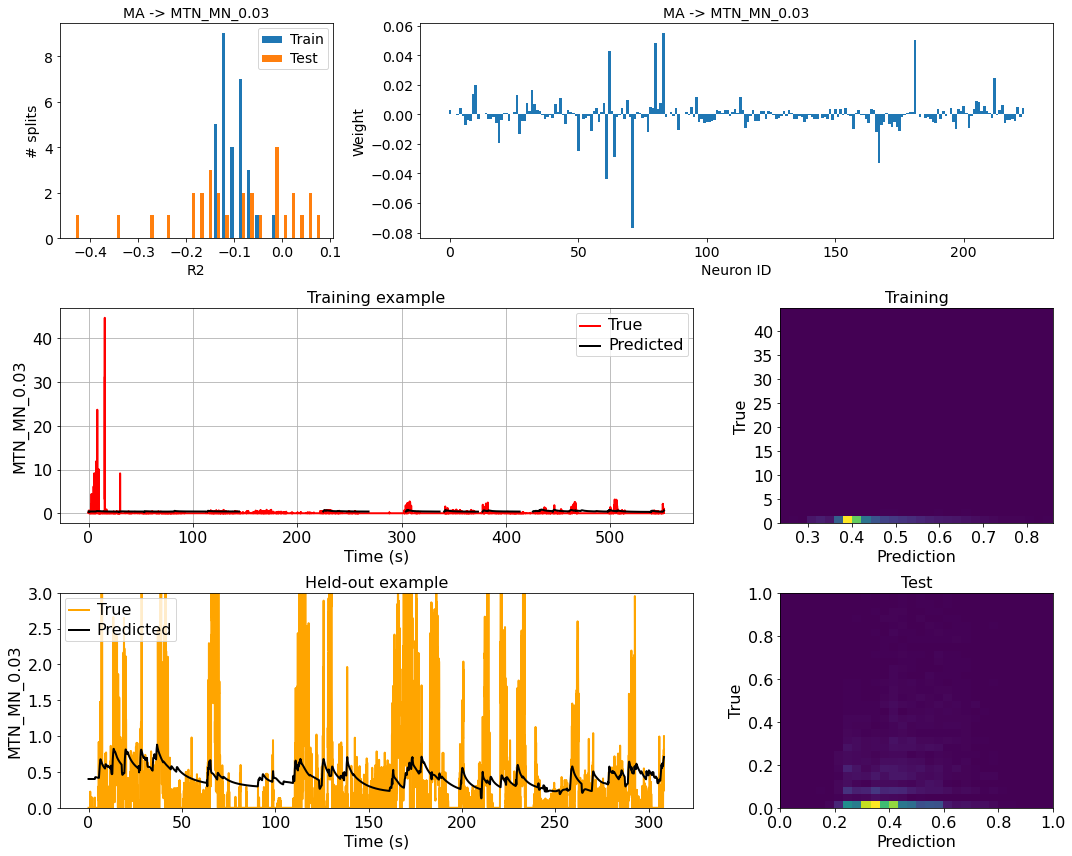

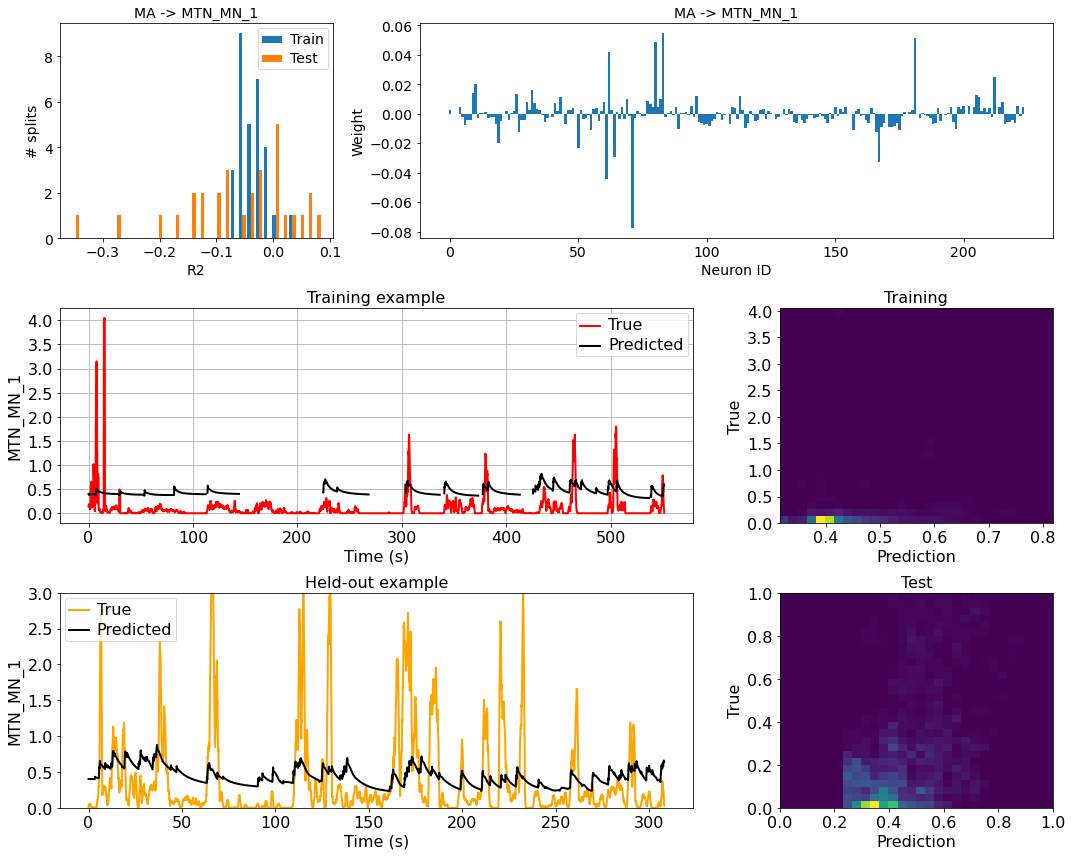

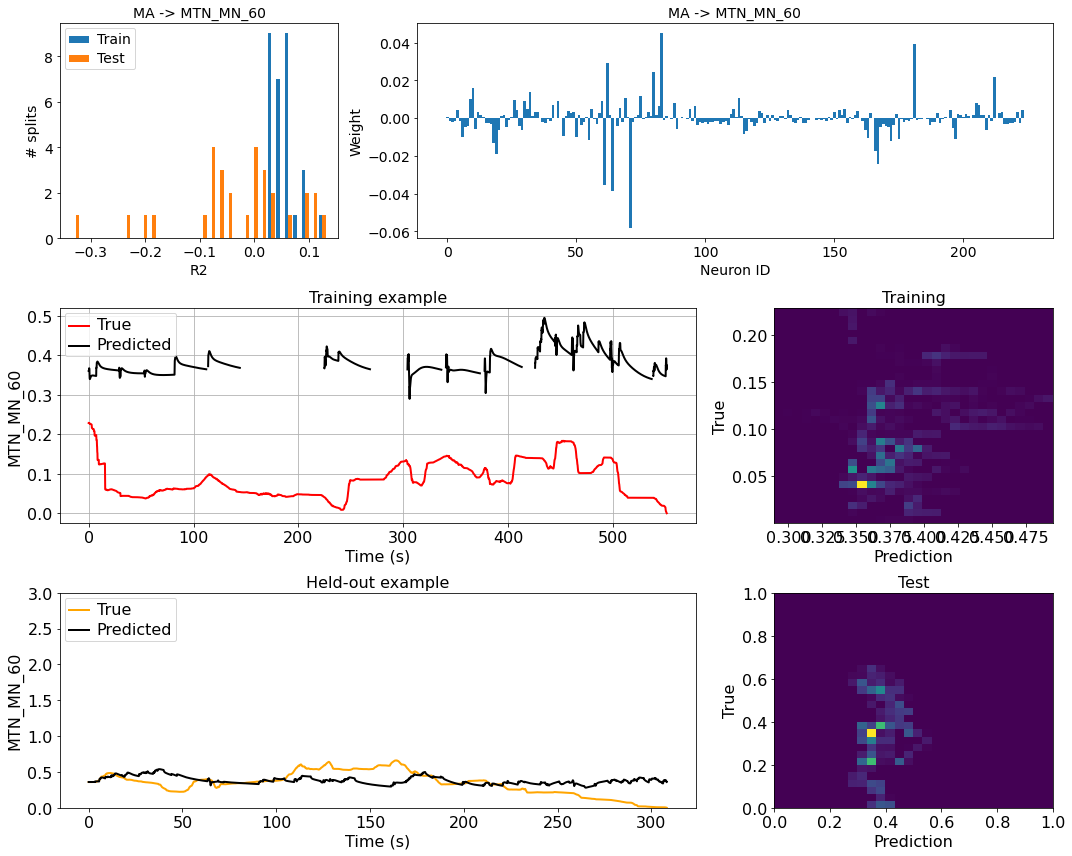

In [32]:
ISPLIT = 0
ITRAIN_PLOT = 0
ITEST_PLOT = 10

FPS = 30.03

nrl_mdl = 'ma'
fsave = f'data/simple/mlv/neur_basic/by_strain/baker_{nrl_mdl}_{STRAIN}_{TARG_BHV.lower()}_masked.npy'
data = np.load(fsave, allow_pickle=True)[0]

for targ in TARGS:

    r2_train = data['r2_train'][targ]
    r2_test = data['r2_test'][targ]

    gs = gridspec.GridSpec(3, 3)

    fig = plt.figure(figsize=(15, 12), tight_layout=True)
    axs = [
        fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:]), fig.add_subplot(gs[1, :-1]), fig.add_subplot(gs[2, :-1]),
        fig.add_subplot(gs[1, -1]), fig.add_subplot(gs[2, -1])
    ]

    axs[0].hist(np.transpose([r2_train, r2_test]), bins=30)
    axs[0].legend(['Train', 'Test'])

    set_plot(axs[0], x_label='R2', y_label='# splits', title=f'{nrl_mdl.upper()} -> {targ}', font_size=14)

    axs[1].bar(np.arange(data['w'][targ].shape[1]), np.mean(data['w'][targ], axis=0), width=1)
    set_plot(axs[1], x_label='Neuron ID', y_label='Weight', title=f'{nrl_mdl.upper()} -> {targ}', font_size=14)

    y_train = data['ys_train'][targ][ISPLIT][ITRAIN_PLOT]
    t_train = np.arange(len(y_train))/FPS

    y_hat_train = data['y_hats_train'][targ][ISPLIT][ITRAIN_PLOT]

    axs[2].plot(t_train, y_train, c='r', lw=2)
    axs[2].plot(t_train, y_hat_train, c='k', lw=2)

    axs[2].legend(['True', 'Predicted'])
    axs[2].grid()

    set_plot(axs[2], x_label='Time (s)', y_label=targ, title='Training example', font_size=16)

    y_test = data['ys_test'][targ][ISPLIT][ITEST_PLOT]
    t_test = np.arange(len(y_test))/FPS

    y_hat_test = data['y_hats_test'][targ][ISPLIT][ITEST_PLOT]

    axs[3].plot(t_test, y_test, c='orange', lw=2)
    axs[3].plot(t_test, y_hat_test, c='k', lw=2)

    axs[3].legend(['True', 'Predicted'], loc='upper left')

    set_plot(axs[3], y_lim=(0, 3), x_label='Time (s)', y_label=targ, title='Held-out example', font_size=16)

    mvalid_train = ~(np.isnan(y_train) | np.isnan(y_hat_train))
    axs[4].hist2d(y_hat_train[mvalid_train], y_train[mvalid_train], bins=30)
    axs[4].set_title('Training')
    
    mvalid_test = ~(np.isnan(y_test) | np.isnan(y_hat_test))
    axs[5].hist2d(y_hat_test[mvalid_test], y_test[mvalid_test], bins=np.linspace(0, 1, 31))
    axs[5].set_title('Test')
    
    for ax in axs[4:]:
        set_plot(ax, x_label='Prediction', y_label='True', font_size=16)